In [2]:
import numpy as np

train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')
test_images = np.load('quickdraw_subset_np/test_images.npy')
test_labels = np.load('quickdraw_subset_np/test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)
print(train_images[0].shape) # 28 x 28
print(train_labels) 

(20000, 28, 28)
(5000, 28, 28)
(28, 28)
[1 3 3 ... 2 3 2]


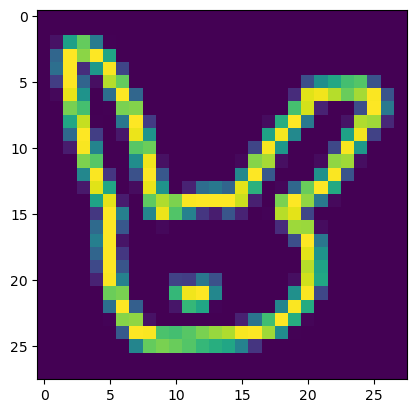

In [7]:
import matplotlib.pyplot as plt

plt.imshow(train_images[1234])


In [3]:
##Feature Extraction

train_flat = train_images.reshape(train_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)

# PCA
#https://medium.com/technological-singularity/build-a-principal-component-analysis-pca-algorithm-from-scratch-7515595bf08b
def PCA_from_Scratch(X, n_components):
    n_rows = X.shape[0]
    X = (X - np.mean(X,axis=0))/(np.std(X,axis=0)+1e-4)
    cov_mat = sum([X[i].reshape(-1, 1) @ X[i].reshape(1, -1) for i in range(n_rows)]) / n_rows
    eigen_values, eigen_vectors  = np.linalg.eig(cov_mat)
    sort = np.argsort(eigen_values)[::-1]
    principal_components = eigen_vectors[:,sort]
    return principal_components[:n_components]

def transform(X,principal_components):
  X = X.copy()
  X_proj = X.dot(principal_components.T)
  return X_proj


# LDA 
#https://www.kaggle.com/code/egazakharenko/linear-discriminant-analysis-lda-from-scratch
class LDA():
  def __init__(self, n_components=None):
     self.n_components = n_components
  def fit(self,X,y):
     self.X = X
     self.y = y
     samples = X.shape[0]
     features= X.shape[1]
     classes, cls_counts = np.unique(y,return_counts=True)
     priors = cls_counts/samples
     X_mean = np.array([X[y==cls].mean(axis=0) for cls in classes])
     betweenCLSdeviation = X_mean - X.mean(axis=0)
     withinCLSdeviation = X - X_mean[y]

     Sb = priors* betweenCLSdeviation.T @ betweenCLSdeviation
     Sw = withinCLSdeviation.T @ withinCLSdeviation / samples
     Sw_inv = np.linalg.pinv(Sw)
     eigvals, eigvecs = np.linalg.eig(Sw_inv @ Sb)
     self.dvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
     self.weights = X_mean @ self.dvecs @ self.dvecs.T
     self.bias = np.log(priors) - 0.5 * np.diag(X_mean @ self.weights.T)
     if self.n_components is None:
        self.n_components = min(classes.size - 1, features)
  def transform(self, X):
    return X @ self.dvecs[:, : self.n_components]

  def predict(self, X_test):
    scores = X_test @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)
  


In [ ]:
pcs = PCA_from_Scratch(train_flat, 2)
train_proj = transform(train_flat, pcs)
train_proj.shape


In [16]:
train_normal = train_flat/255
test_normal = test_flat/255
train_normal.shape
lda = LDA()
lda.fit(train_normal,train_labels)
lda_train = lda.transform(train_normal)
lda_test = lda.transform(test_normal)

In [17]:
class myKNearesNeighbour():
    def __init__(self, k):
        self.k = k
    def fit(self, X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        self.X_test = X_test
        y_pred = np.zeros(self.X_test.shape[0])
        for i, image in enumerate(X_test):
            neighbours = self.findNeighbours(image)
            y_pred[i] = self.mode(neighbours)
        return y_pred
    def findNeighbours(self, image):
        sortedList = np.argsort(self.Euclidean(image)) 
        y_train_sorted = self.y_train[sortedList]
        return y_train_sorted[:self.k]
    def mode(self, vector):
        values, counts = np.unique(vector, return_counts=True)
        return values[np.argmax(counts)]
    def Euclidean(self,image):
        distances = np.sqrt(np.sum((self.X_train - image) ** 2, axis=1))
        return distances
    
        

def score(y_pred, y_true):
        accuracy = np.mean(y_pred == y_true)
        return accuracy
train_normal = train_flat/255
test_normal = test_flat/255

In [23]:
train_normal = train_flat/255
test_normal = test_flat/255

n_neighbours = [3,5,7,9]
scores = []
for k in n_neighbours:
    KNN = myKNearesNeighbour(k)
    KNN.fit(lda_train,train_labels)
    y_pred = KNN.predict(lda_test)
    result = score(y_pred, test_labels)
    scores.append(result)
    print(result)




0.7192
0.734
0.7424
0.7474


In [22]:
scores[0]

<function __main__.score(y_pred, y_true)>

In [38]:
componentAmount = [16, 32, 64, 128, 256]
principal_comps = []
train_transform = []
test_transform = []
y_pred = []
scorePCA = []

for number in componentAmount:
    pcs = PCA_from_Scratch(train_flat, number)
    principal_comps.append(pcs)
    
    train_proj = transform(train_flat, pcs)
    test_proj = transform(test_flat, pcs)
    train_transform.append(train_proj)
    test_transform.append(test_proj)
    
    KNN_PCA = myKNearesNeighbour(3)
    KNN_PCA.fit(train_proj, train_labels)
    pred = KNN_PCA.predict(test_proj)
    y_pred.append(pred)
    
    scorePCA.append(score(pred, test_labels))
    print("One is done")


One is done
One is done
One is done
One is done
One is done


In [39]:
scorePCA


[0.44, 0.549, 0.6848, 0.7766, 0.8148]

In [11]:
class myNaiveBayes():
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}
    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        for w in self.classes:
            X_train_w = X_train[y_train == w]
            P_w = X_train_w.shape[0] / X_train.shape[0] # Prior Densities P(w_j)
            self.priors[w] = P_w
            self.likelihoods[w] = {}
            for x in range(X_train.shape[1]):
                feature_x = X_train_w[:,x]
                mean_x_w = np.mean(feature_x)
                var_x_w = np.var(feature_x)
                self.likelihoods[w][x] = (mean_x_w, var_x_w)

    def gaussianDensity(self,x,mean,var):
        denu = 1.0 / np.sqrt(2.0 * np.pi * (var + 1e-4))
        inexp = -((x - mean) ** 2) / (2 * (var + 1e-4))
        return denu*np.exp(inexp)
    
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            posteriors = {}
            for c in self.classes:
                log_prior = np.log(self.priors[c])
                log_likelihood = 0
                for i in range(len(x)):
                    mean, var = self.likelihoods[c][i]
                    log_likelihood += np.log(self.gaussianDensity(x[i], mean, var))
                posteriors[c] = log_prior+log_likelihood
            y_pred.append(max(posteriors, key=posteriors.get))
        return y_pred

In [13]:
mybayes = myNaiveBayes()
mybayes.fit(train_normal,train_labels)
y_pred = mybayes.predict(test_normal)
score(y_pred,test_labels)

C:\Users\Asus\AppData\Local\Temp\ipykernel_9304\2853722943.py:34: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(self.gaussianDensity(x[i], mean, var))


0.5674

In [3]:
import numpy as np

class myMultiClassLogisticRegression():
    def __init__(self, learning_rate=0.1, maxiterations=10000, mu=0.0):
        """
        :param learning_rate: Step size for gradient descent (eta).
        :param maxiterations: Number of iterations to run gradient descent.
        :param mu: L2 regularization coefficient.
        """
        self.learning_rate = learning_rate
        self.maxiterations = maxiterations
        self.mu = mu  # regularization strength
        self.W = None  # weight matrix

    def OneHotEncoder(self, y_train, num_classes):
        """
        Convert integer labels (0..num_classes-1) into one-hot vectors.
        :param y_train: shape (N,)
        :param num_classes: total number of classes
        :return: one-hot array of shape (N, num_classes)
        """
        y_trainNew = np.zeros((y_train.shape[0], num_classes))
        for i, label in enumerate(y_train):
            y_trainNew[i, label] = 1
        return y_trainNew

    def softmax(self, Z):
        """
        Numerically stable softmax.
        :param Z: shape (N, C) - the logits for each class
        :return: shape (N, C) - the softmax probabilities
        """
        Z_shifted = Z - np.max(Z, axis=1, keepdims=True)  # stability
        exp_Z = np.exp(Z_shifted)
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def loss(self, X, Y, W):
        
        N = X.shape[0]
        logits = X @ W  # shape (N, C)
        P = self.softmax(logits)  # shape (N, C)
        eps = 1e-15
        cross_entropy = -np.mean(np.sum(Y * np.log(P + eps), axis=1))
        # L2 regularization term
        reg_term = self.mu * np.sum(W**2)
        return cross_entropy + reg_term

    def gradient(self, X, Y, W):
        
        N = X.shape[0]
        logits = X @ W  # shape (N, C)
        P = self.softmax(logits)  # shape (N, C)
        grad = (1.0 / N) * (X.T @ (P - Y)) + 2.0 * self.mu * W
        return grad

    def fit(self, X_train, y_train):
       
        self.n_images, self.n_features = X_train.shape
        num_classes = len(np.unique(y_train))

        # One-hot encode the labels
        Y_onehot = self.OneHotEncoder(y_train, num_classes)

        # Initialize weights (d, C)
        self.W = np.zeros((self.n_features, num_classes))

        # Run gradient descent
        for _ in range(self.maxiterations):
            grad = self.gradient(X_train, Y_onehot, self.W)
            self.W -= self.learning_rate * grad

    def predict(self, X_test):
       
        logits = X_test @ self.W  # shape (M, C)
        P = self.softmax(logits)  # shape (M, C)
        return np.argmax(P, axis=1)

        

In [15]:
myLog = myMultiClassLogisticRegression()
myLog.fit(train_normal,train_labels)
y_pred = myLog.predict(test_normal)
score(y_pred,test_labels)

0.7508

In [12]:
import numpy as np

class OneVsAllLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, _lambda=0.1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self._lambda = _lambda
        self.classifiers = None
        self.classes_ = None

    def sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))

    def cost_fun(self, W, X, y):
        N  = X.shape[0]
        h = self.sigmoid(X @ W)
        eps = 1e-15
        cost = -(1.0/N) * (y.T @ np.log(h + eps) + (1 - y).T @ np.log(1 - h + eps)) + (self._lambda / (2*N)) * np.sum(W**2)
        return cost

    def gradient(self, W, X, y):
        N = X.shape[0]
        h = self.sigmoid(X @ W)
        grad = (1.0/N) * X.T @ (h - y) + (self._lambda/N) * W
        return grad

    def fit(self, X, y):
        m, n = X.shape
        self.classes_ = np.unique(y)
        k = len(self.classes_)
        all_theta = np.zeros((k, n))
        for i, cls in enumerate(self.classes_):
            binary_y = (y == cls).astype(float)
            theta = np.zeros(n)
            for _ in range(self.max_iter):
                theta -= self.learning_rate * self.gradient(theta, X, binary_y)
            all_theta[i] = theta
        self.classifiers = all_theta

    def predict(self, X):
        probs = self.sigmoid(X.dot(self.classifiers.T))
        predictions = np.array([self.classes_[np.argmax(probs[i])] for i in range(X.shape[0])])
        return predictions


In [ ]:
learning_rates = [0.01, 0.1, 0.5, 1.0]
lambas = [0, 0.01, 0.05, 0.1, 0.5, 1]
results = []
accuracy = []

def macroF1(y_pred, y_true):
    labels = np.unique(y_true)
    f1_scores = []

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        f1_scores.append(f1)

for lr in learning_rates:
    for lamb in lambas:
        modelOA = OneVsAllLogisticRegression(learning_rate=lr, max_iter=1000, _lambda=lamb)
        
        modelMC = myMultiClassLogisticRegression(learning_rate=lr, maxiterations=1000, mu=lr)
        
        modelOA.fit(train_normal, train_labels)
        y_pred = modelOA.predict(test_normal)
        accuracy = score(y_pred=y_pred,y_true=test_labels)
        macro = macroF1(y_pred=y_pred,y_true=test_labels)            
        results.append((lr, accuracy))
        print("OnevsAll Learning Rate:", lr, "Lambda:", lamb, "Test Accuracy:", accuracy)

        modelMC.fit(train_normal, train_labels)
        y_pred = modelMC.predict(test_normal)
        accuracy = score(y_pred=y_pred,y_true=test_labels)
        macro = macroF1(y_pred=y_pred,y_true=test_labels)            
        results.append((lr, accuracy))
        print("MultiClass Learning Rate:", lr, "Lambda:", lamb, "Test Accuracy:", accuracy)


TypeError: macroF1() got an unexpected keyword argument 'y_test'